In [1]:
import pandas as pd
import numpy as np
from pandasql import sqldf
pd.options.display.max_columns = 1000000
pd.options.display.max_rows = 1000000
import matplotlib.pyplot as plt
from scipy.stats import skew
import matplotlib.ticker

In [3]:
trades = pd.read_csv('trades.csv')
events = pd.read_csv('events.csv')
referrals = pd.read_csv('referrals.csv')
split_test_exposures = pd.read_csv('split_test_exposures.csv')

In the customers who have made signed-up referrals, the distribution of referrals frequency from 06/02/2017 to 09/012017  looks as below. The medium value of the frequency is 3 and maximum value is 2997. Around 66.9% of referrers made <=5 signed up referrals, and around 12% of referrers made >=19 signed up referrals in 3 months. 


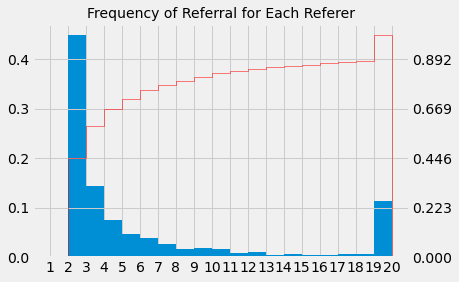

In [8]:
print("In the customers who have made signed-up referrals, the distribution of referrals frequency from 06/02/2017 to 09/012017  looks as below. The medium value of the frequency is 3 and maximum value is 2997. Around 66.9% of referrers made <=5 signed up referrals, and around 12% of referrers made >=19 signed up referrals in 3 months. ");
freq=sqldf('select referrer_user_id,count(*) as freq from referrals group by 1 having count(*)>1 order by 2 desc')
freq['freq'].clip(lower=0, upper=20, inplace=True)    
plt.style.use('fivethirtyeight')
fig,ax = plt.subplots()
plt.xticks(np.arange(1,21,1))
ax.hist(freq.freq, bins=range(1, 21, 1), density=True)
ax1=ax.twinx() 
ax1.hist(freq.freq, bins=range(1,21, 1), density=True, histtype='step', cumulative=1 ,color='red')
plt.title("Frequency of Referral for Each Referer",fontsize=14)
l = ax.get_ylim()
l1 = ax1.get_ylim()
f = lambda x : l1[0]+(x-l[0])/(l[1]-l[0])*(l1[1]-l1[0])
ticks = f(ax.get_yticks())
ax1.yaxis.set_major_locator(matplotlib.ticker.FixedLocator(ticks))
plt.show(); 